### Análisis de series temporales

Python contiene en sm.datasets una serie de conjunto de datos de ejemplo. Entre ellos se encuentra SUNSPOTs, que contiene desde el año 1700 hasta el año 2008 el numero de manchas solares que se identificaron en el sol ese año. La serie temporal consta de un punto por año.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

In [2]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



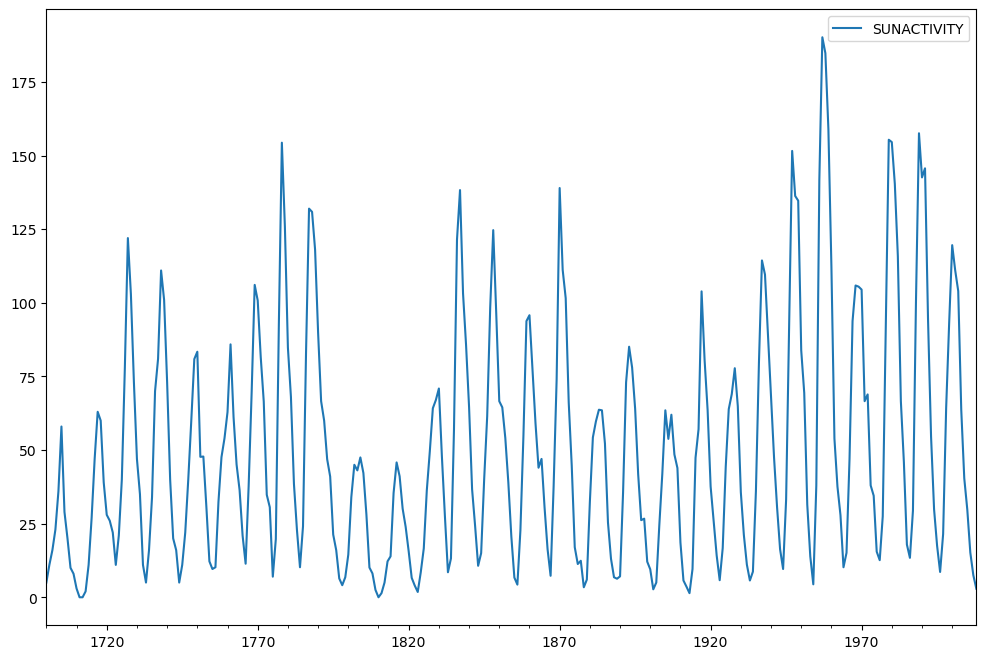

In [125]:
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
dta.index.freq = dta.index.inferred_freq
del dta["YEAR"]
dta.plot(figsize=(12, 8));


In [6]:
dta

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5


### ¿es la serie estacionaria? ¿para que valor de p (p-value)?


In [109]:
sts.adfuller(dta)

(-2.837780724938198,
 0.05307642172812019,
 8,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 2430.50034229055)

Hemos identificado que la serie **no presenta estacionariedad**, ya que la prueba de Dicky Fuller ha arrojado un valor p de 0.05307, que supera el nivel de significancia de 0.05. Con el objetivo de evitar posibles errores al crear los modelos, **procederemos a transformar la serie en una serie estacionaria**.

In [126]:
dta = dta.diff(periods=1)[1:] 

Utilizamos la función .diff para transformar la serie en una serie estacionaria, obteniendo los valores resultado de la diferencia entre cada punto y el punto anterior, eliminando el primer punto. 

In [111]:
sts.adfuller(dta)

(-14.861663428129386,
 1.715552423167133e-27,
 7,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 2428.9093430513367)

Observamos que ahora la serie se ha vuelto estacionaria después de aplicar la función .diff. La prueba de Dickey-Fuller nos arroja un valor p de 1.715552423167133e-27, lo que indica que podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria y, por lo tanto, es estacionaria.

### Ahora descompondremos la señal en sus componentes de tendencia, estacionalidad y ruido. 

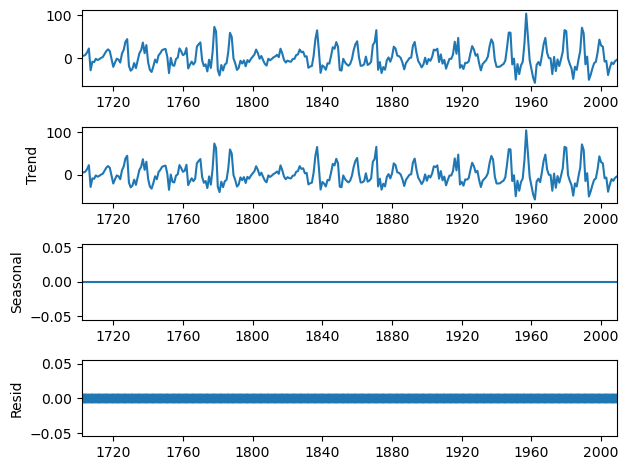

In [112]:
#Hacemos la descomposición sobre la serie ya estacionaria
s_dec_additive = seasonal_decompose(dta, model = "additive")
s_dec_additive.plot()
plt.show()

**Primer grafo**

Identificamos la serie original

**Segundo grafo: Tendencia que ha detectado el algoritmo**

No se observa ninguna tendencia.

**Tercer grafo: Estacionalidad**

La línea recta en cero en la estacionalidad indica que la variación estacional en la serie es constante y no cambia con el tiempo. No hay estacionalidad.


**Residuo: Resultado de la suma de tendencia más estacionalidad y se resta del valor original**

La componente de ruido en los datos es muy pequeña. Básicamente sería todo tendencia.

### Dividimos la señal entre training y testing al 80%

In [127]:
size = int(len(dta)*0.8)
dta, dta_test = dta.iloc[:size], dta.iloc[size:]

In [9]:
dta.tail()

,SUNACTIVITY
1942-12-31,-16.9
1943-12-31,-14.3
1944-12-31,-6.7
1945-12-31,23.6
1946-12-31,59.4


In [10]:
dta_test.head()

,SUNACTIVITY
1947-12-31,59.0
1948-12-31,-15.3
1949-12-31,-1.6
1950-12-31,-50.8
1951-12-31,-14.5


### Creamos un modelo AR(1), MA(1), ARMA(1,1) y un ARMA (3,1)

**AR(1)**

In [12]:
model_ar = ARIMA(dta, order=(1,0,0))

In [13]:
results_ar = model_ar.fit()

In [14]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  246
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1058.870
Date:                Sun, 07 May 2023   AIC                           2123.739
Time:                        01:42:51   BIC                           2134.255
Sample:                    12-31-1701   HQIC                          2127.974
                         - 12-31-1946                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6491      2.950      0.220      0.826      -5.132       6.430
ar.L1          0.5287      0.049     10.717      0.000       0.432       0.625
sigma2       320.3771     23.378     13.704      0.000     274.556     366.198
===================================================================================
Ljung-Box (L1) (Q):                   4.54   Jarque-Bera (JB):                25.56
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.04
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Por el momento observamos que el coeficiente φ es estadisticamente significativo, es buena señal.

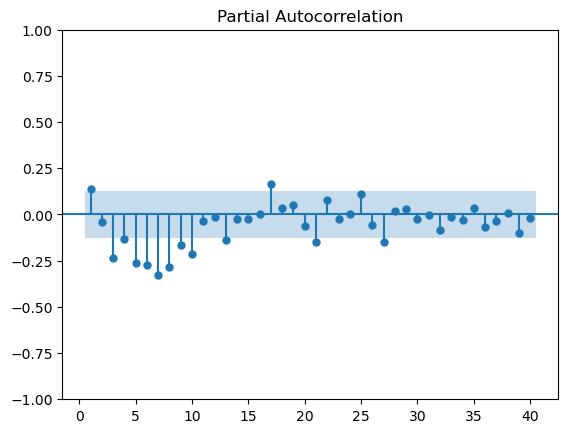

In [15]:
#Ahora queremos ver si hay autocorrelaciones en el residuo, como es un modelo AR realizamos PACF
sgt.plot_pacf(results_ar.resid, lags = 40,  zero = False, method = ('ols'))
plt.show()

El residuo del modelo que acabamos de crear tiene autocorrelaciones en los primeros retrasos, por lo tanto **no es ruido blanco**, todabía queda señal por capturar, se necesita crear un modelo más complejo.

**MA(1)**

In [17]:
model_ma = ARIMA(dta, order=(0,0,1))

In [18]:
results_ma = model_ma.fit()

In [19]:
results_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  246
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1061.707
Date:                Sun, 07 May 2023   AIC                           2129.413
Time:                        01:43:16   BIC                           2139.929
Sample:                    12-31-1701   HQIC                          2133.648
                         - 12-31-1946                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4587      1.968      0.233      0.816      -3.399       4.316
ma.L1          0.4767      0.050      9.621      0.000       0.380       0.574
sigma2       327.9517     25.583     12.819      0.000     277.810     378.093
===================================================================================
Ljung-Box (L1) (Q):                   4.09   Jarque-Bera (JB):                 9.93
Prob(Q):                              0.04   Prob(JB):                         0.01
Heteroskedasticity (H):               1.09   Skew:                             0.28
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

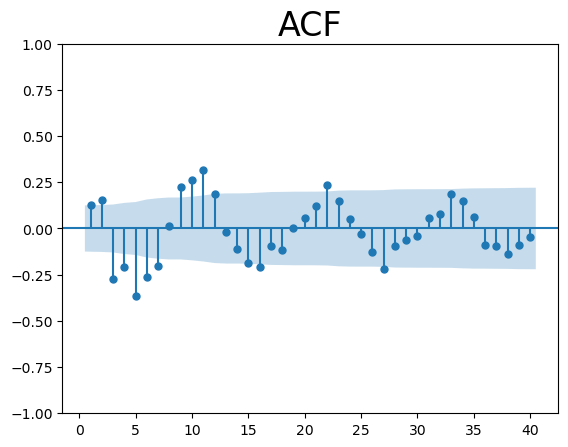

In [20]:
#Ahora queremos ver si hay autocorrelaciones en el residuo, como es un modelo MA realizamos ACF
sgt.plot_acf(results_ma.resid, zero = False, lags = 40)
plt.title("ACF",size=24)
plt.show()

Al analizar los residuos del segundo modelo, se observa que aún existen retrasos estadísticamente significativos al comienzo de la serie, lo cual indica que la señal de residuo **no puede considerarse como ruido blanco**. 

**ARMA(1,1)**

In [21]:
model_arma = ARIMA(dta, order=(1,0,1))
results_arma = model_arma.fit()
results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  246
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1054.894
Date:                Sun, 07 May 2023   AIC                           2117.789
Time:                        01:43:44   BIC                           2131.810
Sample:                    12-31-1701   HQIC                          2123.435
                         - 12-31-1946                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5863      2.667      0.220      0.826      -4.641       5.813
ar.L1          0.3749      0.087      4.329      0.000       0.205       0.545
ma.L1          0.2349      0.086      2.729      0.006       0.066       0.404
sigma2       310.1204     23.185     13.376      0.000     264.678     355.563
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                21.70
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.07
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

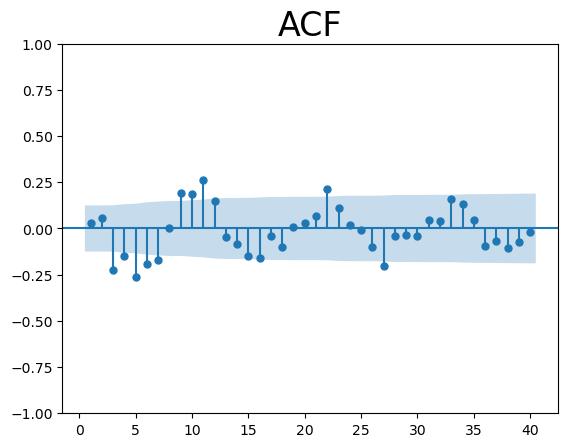

In [22]:
#Ahora queremos ver si hay autocorrelaciones en el residuo, como es un modelo ARMA realizamos ACF
sgt.plot_acf(results_arma.resid, zero = False, lags = 40)
plt.title("ACF",size=24)
plt.show()

 La señal de residuo aun **no es ruido blanco**

**ARMA (3,1)**

In [23]:
model_arma3 = ARIMA(dta.SUNACTIVITY, order=(3,0,1))
results_arma3 = model_arma3.fit()
results_arma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  246
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -1010.037
Date:                Sun, 07 May 2023   AIC                           2032.074
Time:                        01:45:02   BIC                           2053.106
Sample:                    12-31-1701   HQIC                          2040.543
                         - 12-31-1946                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1691      0.296      0.571      0.568      -0.412       0.750
ar.L1          1.2042      0.070     17.136      0.000       1.066       1.342
ar.L2         -0.4464      0.092     -4.829      0.000      -0.628      -0.265
ar.L3         -0.1905      0.066     -2.896      0.004      -0.319      -0.062
ma.L1         -0.8881      0.046    -19.295      0.000      -0.978      -0.798
sigma2       213.7379     17.050     12.536      0.000     180.320     247.156
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                26.85
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.45
Prob(H) (two-sided):                  0.60   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

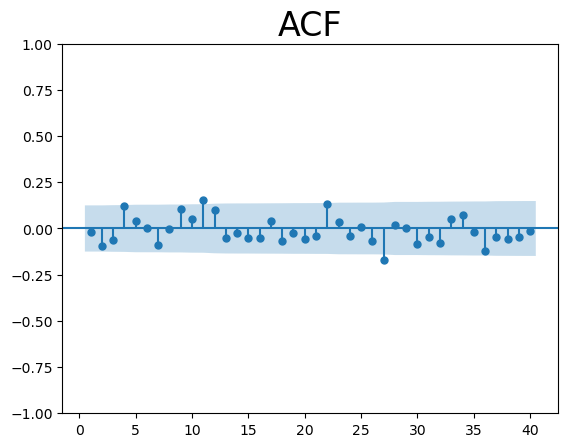

C:\Users\dogst\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


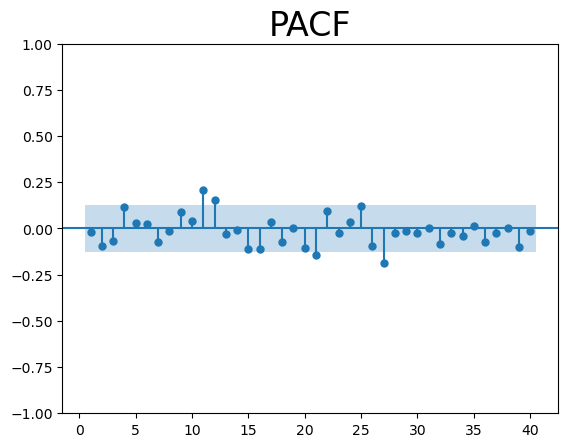

In [54]:
sgt.plot_acf(results_arma3.resid, zero = False, lags = 40)
plt.title("ACF",size=24)
plt.show()

sgt.plot_pacf(results_arma3.resid, zero = False, lags = 40)
plt.title("PACF",size=24)
plt.show()

Observamos que los primeros 10 retrasos no son significativos, con excepción del cuarto que presenta algo de ambiguedad, no se identifica claramente si son estadísticamente significativos.





In [25]:
print("AR(1):  \t LL = ", results_ar.llf, "\t AIC = ", results_ar.aic,  "\t BIC = ", results_ar.bic)
print("MA(1):  \t LL = ", results_ma.llf, "\t AIC = ", results_ma.aic, "\t BIC = ", results_ma.bic)
print("ARMA(1,1):  \t LL = ", results_arma.llf, "\t AIC = ", results_arma.aic,  "\t BIC = ", results_arma.bic)
print("ARMA(3,1):  \t LL = ", results_arma3.llf, "\t AIC = ", results_arma3.aic, "\t BIC = ", results_arma3.bic)

AR(1):  	 LL =  -1058.869710069509 	 AIC =  2123.739420139018 	 BIC =  2134.255414746815
MA(1):  	 LL =  -1061.7066427927075 	 AIC =  2129.413285585415 	 BIC =  2139.929280193212
ARMA(1,1):  	 LL =  -1054.894463361546 	 AIC =  2117.788926723092 	 BIC =  2131.8102528668214
ARMA(3,1):  	 LL =  -1010.0372306737705 	 AIC =  2032.074461347541 	 BIC =  2053.1064505631352


El modelo ARMA(3,1) destaca por tener los valores más bajos de AIC y BIC, además de tener el valor más alto de LL en comparación con los otros modelos evaluados. También es importante mencionar que todos los coeficientes de este modelo son significativos.

### Identificaremos la dimension optima para un modelo autoregresivo (AR)  

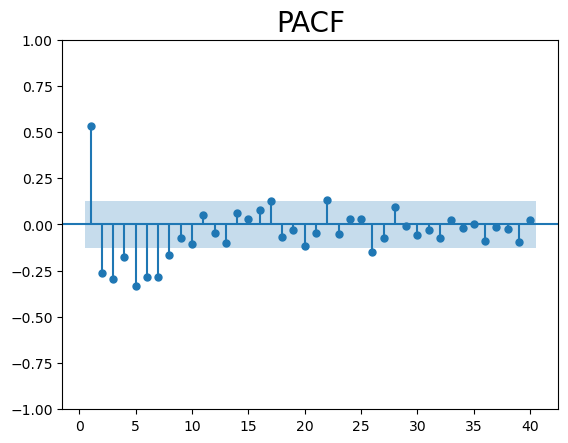

In [26]:
sgt.plot_pacf(dta, lags = 40,  zero = False, method = ('ols')) #Observaremos el número de retrasos que son relevantes para AR
plt.title("PACF", size = 20)
plt.show()

Al analizar los retrasos que son estadísticamente significativos, podemos tener una idea de cuántos retrasos debemos considerar en nuestro modelo. Para ello, vamos a explorar los primeros ocho retrasos y utilizaremos la función PACF para comenzar con los modelos AR. Esto se debe a que la PACF recoge la información sobre la influencia directa de una observación con k retrasos sobre la observación actual, lo que es fundamental en un modelo autorregresivo.

In [27]:
def LLR_test(mod_1, mod_2, DF=1): #Definimos la función deL test LLR 
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [56]:
# Definimos los modelos desde AR(1) hasta AR(8)
model_ar_1 = ARIMA(dta, order=(1, 0, 0))
results_ar_1 = model_ar_1.fit()

model_ar_2 = ARIMA(dta, order=(2, 0, 0))
results_ar_2 = model_ar_2.fit()

model_ar_3 = ARIMA(dta, order=(3, 0, 0))
results_ar_3 = model_ar_3.fit()

model_ar_4 = ARIMA(dta, order=(4, 0, 0))
results_ar_4 = model_ar_4.fit()

model_ar_5 = ARIMA(dta, order=(5, 0, 0))
results_ar_5 = model_ar_5.fit()

model_ar_6 = ARIMA(dta, order=(6, 0, 0))
results_ar_6 = model_ar_6.fit()

model_ar_7 = ARIMA(dta, order=(7, 0, 0))
results_ar_7 = model_ar_7.fit()

model_ar_8 = ARIMA(dta, order=(8, 0, 0))
results_ar_8 = model_ar_8.fit()

In [57]:
#Imprimimos los resultados del LL,AIC y BIC
print("AR(1):\tLL = ", results_ar_1.llf, "\tAIC = ", results_ar_1.aic, "\tBIC = ", results_ar_1.bic)
print("AR(2):\tLL = ", results_ar_2.llf, "\tAIC = ", results_ar_2.aic, "\tBIC = ", results_ar_2.bic)
print("AR(3):\tLL = ", results_ar_3.llf, "\tAIC = ", results_ar_3.aic, "\tBIC = ", results_ar_3.bic)
print("AR(4):\tLL = ", results_ar_4.llf, "\tAIC = ", results_ar_4.aic, "\tBIC = ", results_ar_4.bic)
print("AR(5):\tLL = ", results_ar_5.llf, "\tAIC = ", results_ar_5.aic, "\tBIC = ", results_ar_5.bic)
print("AR(6):\tLL = ", results_ar_6.llf, "\tAIC = ", results_ar_6.aic, "\tBIC = ", results_ar_6.bic)
print("AR(7):\tLL = ", results_ar_7.llf, "\tAIC = ", results_ar_7.aic, "\tBIC = ", results_ar_7.bic)
print("AR(8):\tLL = ", results_ar_8.llf, "\tAIC = ", results_ar_8.aic, "\tBIC = ", results_ar_8.bic)

AR(1):	LL =  -1058.869710069509 	AIC =  2123.739420139018 	BIC =  2134.255414746815
AR(2):	LL =  -1050.6160582234525 	AIC =  2109.232116446905 	BIC =  2123.253442590634
AR(3):	LL =  -1039.8185382769516 	AIC =  2089.637076553903 	BIC =  2107.163734233565
AR(4):	LL =  -1036.0940123143428 	AIC =  2084.1880246286855 	BIC =  2105.2200138442795
AR(5):	LL =  -1022.6032946686001 	AIC =  2059.2065893372 	BIC =  2083.743910088727
AR(6):	LL =  -1012.462274487986 	AIC =  2040.924548975972 	BIC =  2068.967201263431
AR(7):	LL =  -1002.5372539813889 	AIC =  2023.0745079627777 	BIC =  2054.622491786169
AR(8):	LL =  -999.2832576090339 	AIC =  2018.5665152180677 	BIC =  2053.6198305773914


In [58]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1, results_ar_2)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_2, results_ar_3)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_3, results_ar_4)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_4, results_ar_5)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_5, results_ar_6)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_6, results_ar_7)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_7, results_ar_8)))


LLR test p-value = 0.0

LLR test p-value = 0.0

LLR test p-value = 0.006

LLR test p-value = 0.0

LLR test p-value = 0.0

LLR test p-value = 0.0

LLR test p-value = 0.011


In [59]:
results_ar_8.summary() #Desplegamos AR(8)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  246
Model:                 ARIMA(8, 0, 0)   Log Likelihood                -999.283
Date:                Sun, 07 May 2023   AIC                           2018.567
Time:                        03:06:11   BIC                           2053.620
Sample:                    12-31-1701   HQIC                          2032.681
                         - 12-31-1946                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2080      0.485      0.429      0.668      -0.743       1.159
ar.L1          0.2616      0.051      5.102      0.000       0.161       0.362
ar.L2         -0.2216      0.054     -4.073      0.000      -0.328      -0.115
ar.L3         -0.3250      0.070     -4.652      0.000      -0.462      -0.188
ar.L4         -0.1388      0.081     -1.705      0.088      -0.298       0.021
ar.L5         -0.2752      0.074     -3.733      0.000      -0.420      -0.131
ar.L6         -0.2071      0.074     -2.799      0.005      -0.352      -0.062
ar.L7         -0.2324      0.074     -3.155      0.002      -0.377      -0.088
ar.L8         -0.1643      0.054     -3.046      0.002      -0.270      -0.059
sigma2       195.4289     14.444     13.530      0.000     167.118     223.739
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                34.80
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.44
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Podemos observar que a medida que aumentamos el orden del modelo AR, la mejora en la calidad del modelo ha sido estadísticamente significativa hasta el modelo de orden 8. Durante el proceso de ajuste, los modelos fueron mejorando gradualmente hasta alcanzar el AR(8), lo que indica que el modelo AR(8) puede capturar mejor las características de los datos.

Además, al evaluar cuidadosamente los criterios BIC, AIC y LL, hemos seleccionado el modelo AR(8) como el mejor modelo para este ejercicio. Es importante destacar que todos los coeficientes del modelo son estadísticamente significativos, excepto uno, lo que indica que el modelo puede ser confiable para hacer predicciones.

### Analizaremos los residuos del modelo obtenido el el punto anterior.

Ahora vamos a evaluar si el modelo AR(8) es apropiado analizando sus residuos. Queremos asegurarnos de que la señal residual, es decir la diferencia entre nuestro modelo y la señal original, sea ruido blanco.

In [60]:
dta['residuos'] = results_ar_8.resid #Cogemos los residuos

In [61]:
print("La media de los residuos es " + str(results_ar_8.resid.mean()) + "\nLa varianza de los residuos es " + str(round(results_ar_8.resid.var(),3)))

La media de los residuos es 0.0643256062334399
La varianza de los residuos es 197.732


In [40]:
sts.adfuller(dta.residuos) #Hacemos la prueba de Dickey-Fuller


(-15.65706890101594,
 1.5706049810874982e-28,
 0,
 245,
 {'1%': -3.4573260719088132,
  '5%': -2.873410402808354,
  '10%': -2.573095980841316},
 1868.1959576100398)

Si cogemos el residuo del modelo 8 observamos que si **es estacionario**, debido a que el valor de p es menor que 0.05, por lo que se rechaza la hipótesis nula.

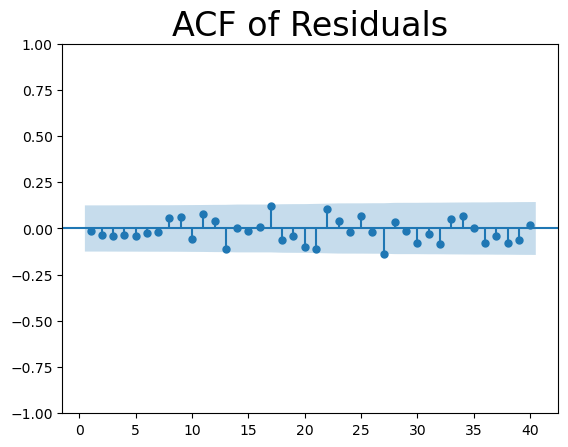

C:\Users\dogst\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


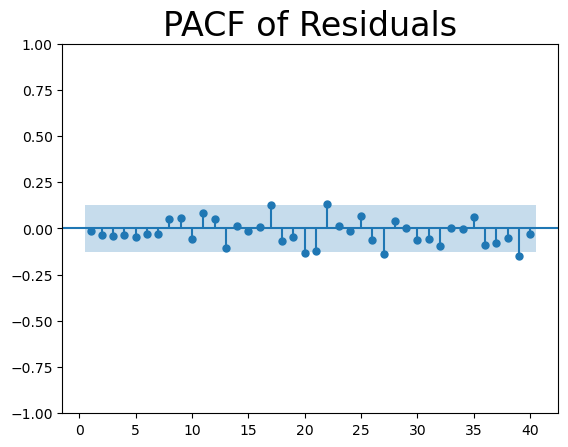

In [41]:
sgt.plot_acf(dta.residuos, zero = False, lags = 40)
plt.title("ACF of Residuals",size=24)
plt.show()

sgt.plot_pacf(dta.residuos, zero = False, lags = 40)
plt.title("PACF of Residuals",size=24)
plt.show()

Podemos concluir que los residuos del modelo **tenemos ruido blanco**. Esto se debe a que los primeros 16 retrasos no presentan autocorrelaciones significativas en las gráficas ACF y PACF, lo cual indica que los residuos están distribuidos aleatoriamente en el tiempo. Aunque existen autocorrelaciones en 2 retrasos para ACF y en 6 para PACF, estos valores son muy bajos y no son relevantes. Además, cabe destacar que estas autocorrelaciones solo se presentan hasta el retraso 17, lo cual confirma la presencia de ruido blanco en los residuos.

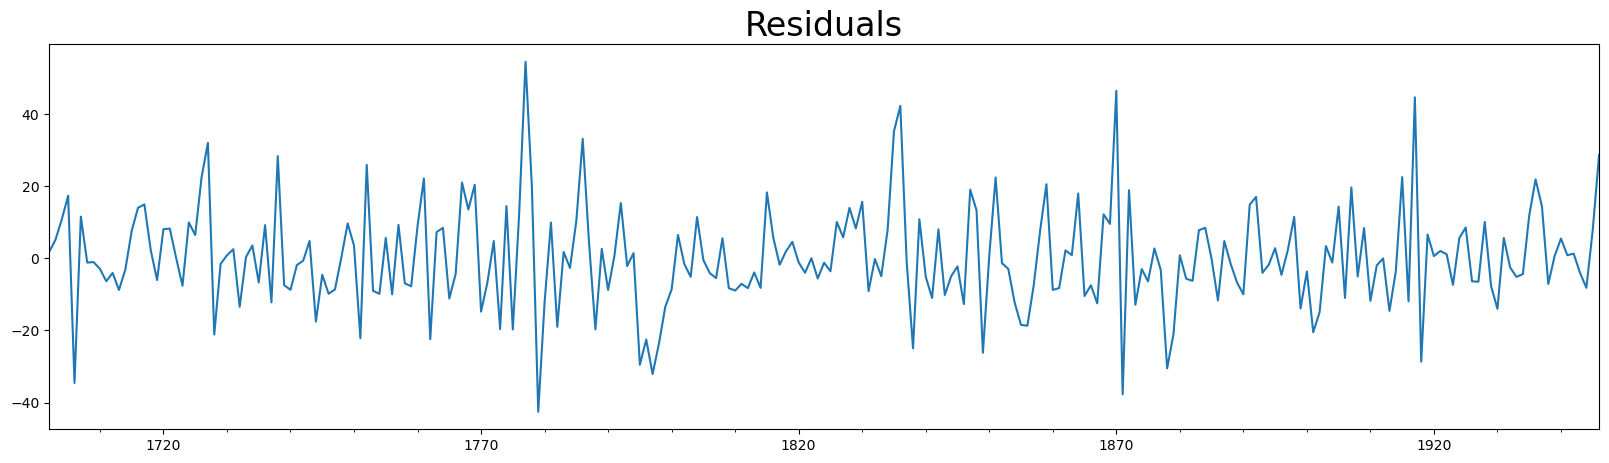

In [42]:
dta.residuos[1:].plot(figsize=(20,5))
plt.title("Residuals",size=24)
plt.show()

Es **ruido blanco** ya que no se observa ningún patrón.

### Compararemos las predicciones con los datos de test entre AR(1), ARMA(3,1) y el modelo obtenido de forma automatica. 

In [128]:
#Ajustamos el modelo AR(1)
model_ar1 = ARIMA(dta, order=(1,0,0))  
results_ar1 = model_ar1.fit()
predictions_ar1 = results_ar1.predict(start=len(dta), end=len(dta)+len(dta_test)-1, dynamic=False).rename('AR(1) Predictions')

#Ajustamos el modelo ARMA(3,1)
model_arma = ARIMA(dta, order=(3,0,1))  
results_arma = model_arma.fit()
predictions_arma = results_arma.predict(start=len(dta), end=len(dta)+len(dta_test)-1, dynamic=False).rename('ARMA(3,1) Predictions')

#Ajustamos modelo automático
model_auto = auto_arima(dta, start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, d=0, 
                        suppress_warnings=True)
results_auto = model_auto.fit(dta)
predictions_auto = results_auto.predict(n_periods=len(dta_test), dynamic=False).rename('Auto Model Predictions')

#Y comparamos los modelos
labels = ['AR(1)', 'ARMA(3,1)', 'Auto Model']
preds = [predictions_ar1, predictions_arma, predictions_auto]

for i in range(3):
    error = mean_squared_error(dta_test, preds[i])
    print(f'{labels[i]} RMSE: {error:11.10}')

AR(1) RMSE: 1092.139526
ARMA(3,1) RMSE: 900.3507821
Auto Model RMSE: 673.8095127


In [129]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  246
Model:               SARIMAX(5, 0, 2)   Log Likelihood                -998.207
Date:                Sun, 07 May 2023   AIC                           2012.413
Time:                        08:39:44   BIC                           2040.456
Sample:                    12-31-1701   HQIC                          2023.705
                         - 12-31-1946                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5505      0.191      8.100      0.000       1.175       1.926
ar.L2         -1.0692      0.232     -4.607      0.000      -1.524      -0.614
ar.L3          0.0819      0.166      0.492      0.622      -0.244       0.408
ar.L4          0.1675      0.124      1.346      0.178      -0.076       0.411
ar.L5         -0.2294      0.096     -2.383      0.017      -0.418      -0.041
ma.L1         -1.3146      0.202     -6.517      0.000      -1.710      -0.919
ma.L2          0.5065      0.178      2.850      0.004       0.158       0.855
sigma2       193.6414     13.866     13.966      0.000     166.465     220.817
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                39.21
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.49
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo automático es el que obtuvo **el mejor RMSE con un valor de 673.80**. Por lo tanto, se puede concluir que **el modelo automático es mejor en este caso** que los modelos AR(1) y ARMA(3,1) que se ajustaron manualmente.

Esto se debe a que el modelo automático utiliza un proceso de selección automática para encontrar la mejor combinación de parámetros y modelos que se ajusten a los datos, lo que permite obtener un modelo más preciso en predicciones.

### Usando el conjunto entero de datos y el modelo seleccionado en el punto anterior, reentrenaremos el modelo con el dataset completo y lo aplicaremos para obtener una estimacion del numero de manchas solares en los siguientes 10 años.

In [51]:
from sklearn.metrics import mean_squared_error

In [130]:
#Cargamos la serie completa para evitar errores y la volvemos estacionaria
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
dta.index.freq = dta.index.inferred_freq
del dta["YEAR"]
dta = dta.diff(periods=1)[1:] 

In [132]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\dogst\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dogst\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


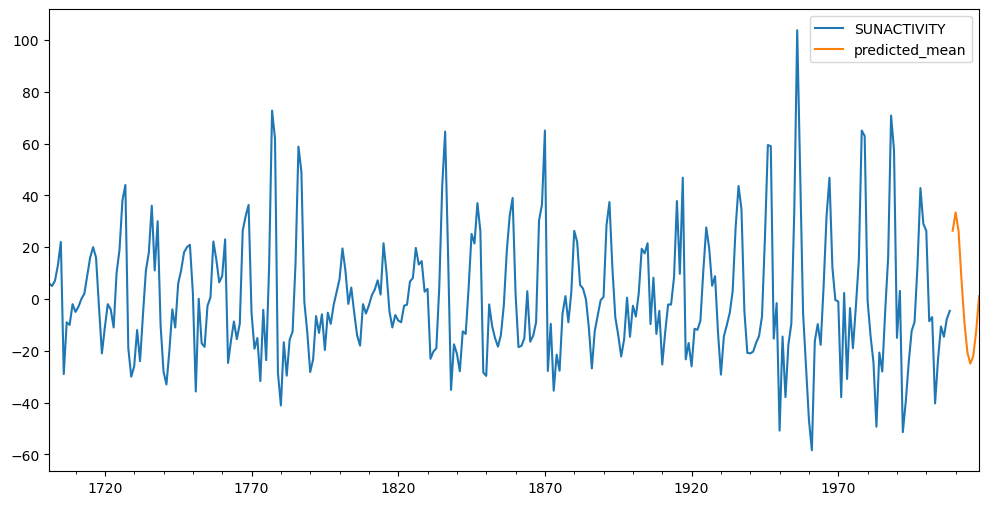

In [133]:
#Reentrenamos el modelo SARIMAX(5,0,2) con toda la serie completa
model_sarimax = SARIMAX(dta, order=(5, 0, 2))
results = model_sarimax.fit()

#Realizamos las predicciones
start = len(dta)
end = len(dta) + 10*12 #aquí especificamos que queremos la predicción para diez años
future_index = pd.date_range(start=dta.index[-1], periods=end-start+1, freq='M')[1:]

predictions = results.predict(start=future_index[0], end=future_index[-1])

#Graficamos las predicciones a diez años
dta.plot(legend=True)
predictions.plot(legend=True, figsize=(12,6));
